# Hyperfine structure of alkali atoms in a magnetic field

In [19]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas as pd
%matplotlib notebook

We plot the eigenspectrum of a Hamiltonian which considers magnetic dipole and electric quadrupole internal hyperfine structure, as well as coupling to an external magnetic field,
$$H = A_{hfs} \vec{I}\cdot\vec{J} + B_{hfs} \frac{3(\vec{I}\cdot\vec{J})^2 + 3\vec{I}\cdot\vec{J}/2 - \vec{I}^2 \vec{J}^2 }{2I(2I-1)J(2J-1)}+ (g_I I_z + g_J J_z)\mu_B B_z/h,$$
for arbitrary nuclear/electronic angular momentum $I,J$. Recall for $J=1/2$ and $B_{hfs} = 0$ (no electric quadrupole), the Breit-Rabi formula offers an analytical solution.

<IPython.core.display.Javascript object>


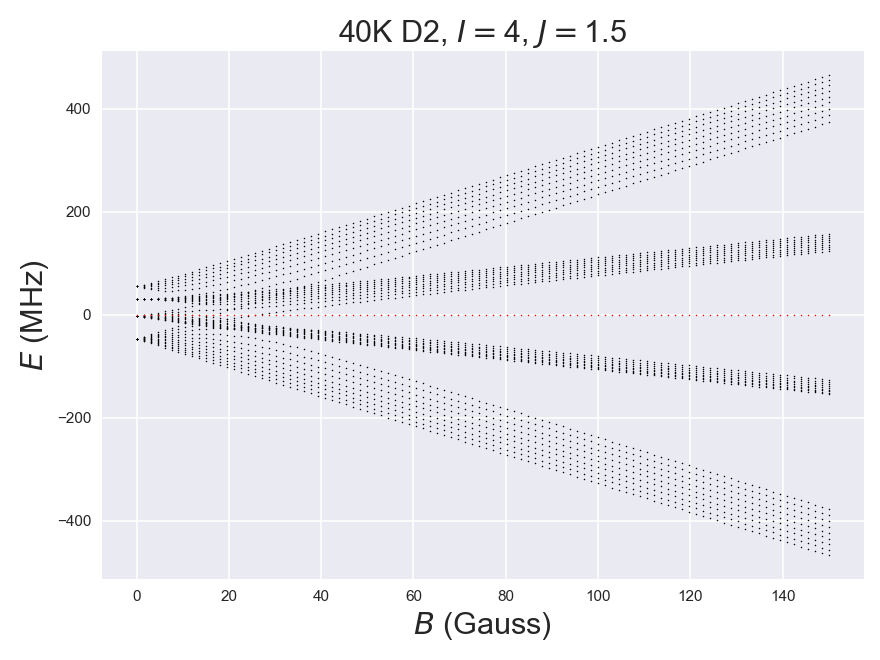

In [66]:
%matplotlib notebook
mu_0 = 1.4 #MHz/Gauss
def spectrum_at_Bfield(Bz,
                      manifold = '40K D2', 
                      show_qtm_nums = True):
    
    if manifold == '40K D2':
    #values taken from Tiecke
        I = 4 
        J = 3/2 
        ah = -7.585
        bh = -3.445
        g_I = 0.00017649 
        g_J = 1.334102228
        plt.title(r'40K D2, $I=${I}, $J=${J}'.format(I=I, J=J), fontsize = 20)
    
    H_hfs = 0
    I_dot_J, I_sq, J_sq = 0, 0, 0
    for J_i in [spin_Jx, spin_Jy, spin_Jz]:
        I_dot_J += tensor(J_i(I), J_i(J))
        I_sq += tensor(J_i(I)**2, qeye(int(2*J + 1)))
        J_sq += tensor(qeye(int(2*I + 1)), J_i(J)**2)
    H_hfs = ah * I_dot_J
    H_hfs += bh / (2 * I * (2*I - 1) * J * (2*J-1)) * (3 * I_dot_J / 2 + 3* (I_dot_J)**2 - I_sq * J_sq)
    #external field term
    I_z, J_z = tensor(spin_Jz(I), qeye(int(2*J + 1))), tensor(qeye(int(2*I + 1)),spin_Jz(J))
    H = H_hfs + (g_I * I_z +  g_J * J_z) * mu_0 * Bz
    eigvals, eigvecs = H.eigenstates()
    data = {'B_field (G)': np.ones_like(eigvals) * Bz, 'eigenenergy (MHz)': eigvals}
    if show_qtm_nums:
        def expectation_and_stdev(operator):
            expectation = np.array([(eigvec.dag() * operator * eigvec)[0] for eigvec in eigvecs])
            stdev = np.ones_like(expectation)
            for idx in range(len(expectation)):
                stdev[idx] = np.sqrt((eigvecs[idx].dag() * (operator - expectation[idx])**2 * eigvecs[idx])[0])
            expectation, stdev = np.real(expectation), np.real(stdev)
            return expectation.flatten(), stdev.flatten()
            
        #calculate expectations and standard deviations of F^2, Fz
        mF_expectation, _ = expectation_and_stdev(I_z + J_z)
        F_sq = 0
        for J_i in [spin_Jx, spin_Jy, spin_Jz]:
            F_sq += (tensor(J_i(I), qeye(int(2*J + 1))) + tensor(qeye(int(2*I + 1)), J_i(J))) ** 2
        F_sq_expectation, F_sq_stdev = expectation_and_stdev(F_sq)
            
        #calculate expectations and standard deviations of Jz, Iz
        mJ_expectation, mJ_stdev = expectation_and_stdev(J_z)
        mI_expectation, mI_stdev = expectation_and_stdev(I_z)
        data.update({'mF_expectation':mF_expectation,
#                'mF_stdev': mF_stdev,
               'F^2_expectation': F_sq_expectation,
                'F': .5 * (np.sqrt(4 * F_sq_expectation + 1) - 1), #invert F^2 ~ F(F+1)
               'F^2_stdev': F_sq_stdev,
               'mI_expectation': mI_expectation,
               'mI_stdev': mI_stdev,
               'mJ_expectation': mJ_expectation,
               'mJ_stdev': mJ_stdev})
    spectrum_df = pd.DataFrame(data)
    spectrum_df.sort_values(by='eigenenergy (MHz)', inplace=True)
    return spectrum_df
        
def plot_E_vs_B(B_min = 0, B_max = 150, n_pts = 100):
    plt.close()
    plt.style.use('seaborn')
    plt.figure(figsize = (8,6))
    for Bz in np.linspace(B_min,B_max,n_pts):
        eigvals = spectrum_at_Bfield(Bz)['eigenenergy (MHz)']
        plt.plot(np.ones_like(eigvals)*Bz, eigvals, 'ko', markersize = '1')
        plt.plot(Bz, np.mean(eigvals), 'ro', markersize = '1')
    plt.xlabel(r'$B$ (Gauss)', fontsize = 20)
    plt.ylabel(r'$E$ (MHz)', fontsize = 20)
    plt.tight_layout()
    plt.show()
    
plot_E_vs_B()

## Good quantum numbers
Below we show $\langle F_z\rangle, \langle F^2\rangle, \langle I_z\rangle, \langle J_z\rangle$ and their standard deviations, where the standard deviation squared is $\sigma^2_\Omega = {\langle (\Omega - \langle \Omega \rangle)^2\rangle}$. Small standard deviation indicates an approximately good quantum number.

In [67]:
spectrum_at_Bfield(0.1)

,B_field (G),eigenenergy (MHz),mF_expectation,F^2_expectation,F,F^2_stdev,mI_expectation,mI_stdev,mJ_expectation,mJ_stdev
0,0.1,-46.651510,-5.5,35.750000,5.500000,0.000000,-4.000000,0.000000,-1.500000,0.000000
1,0.1,-46.600710,-4.5,35.749961,5.499997,0.020712,-3.271052,0.444503,-1.228948,0.444503
2,0.1,-46.549879,-3.5,35.749930,5.499994,0.027800,-2.542437,0.596619,-0.957563,0.596619
3,0.1,-46.499017,-2.5,35.749906,5.499992,0.032115,-1.814155,0.689211,-0.685845,0.689211
4,0.1,-46.448124,-1.5,35.749891,5.499991,0.034703,-1.086208,0.744752,-0.413792,0.744752
5,0.1,-46.397199,-0.5,35.749883,5.499990,0.035936,-0.358597,0.771222,-0.141403,0.771222
6,0.1,-46.346243,0.5,35.749882,5.499990,0.035952,0.368679,0.771552,0.131321,0.771552
7,0.1,-46.295255,1.5,35.749890,5.499991,0.034747,1.095619,0.745709,0.404381,0.745709
8,0.1,-46.244236,2.5,35.749906,5.499992,0.032184,1.822221,0.690687,0.677779,0.690687
9,0.1,-46.193185,3.5,35.749929,5.499994,0.027884,2.548486,0.598408,0.951514,0.598408
